In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [95]:
# Creates the dataframe

store_sales = pd.read_csv(
     'train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)

store_sales.head(8)

,date,store_nbr,family,sales
0,2013-01-01,1,AUTOMOTIVE,0.0
1,2013-01-01,1,BABY CARE,0.0
2,2013-01-01,1,BEAUTY,0.0
3,2013-01-01,1,BEVERAGES,0.0
4,2013-01-01,1,BOOKS,0.0
5,2013-01-01,1,BREAD/BAKERY,0.0
6,2013-01-01,1,CELEBRATION,0.0
7,2013-01-01,1,CLEANING,0.0


In [96]:
# Takes the averagle sales by date 
average_sales_df = store_sales.groupby('date').mean()
average_sales_df.head(8)

,sales
date,
2013-01-01,1.409438
2013-01-02,278.390808
2013-01-03,202.840195
2013-01-04,198.911148
2013-01-05,267.873230
2013-01-06,291.636017
2013-01-07,188.621094
2013-01-08,178.646347


In [97]:
# Vectorizes average sales
average_sales = store_sales.groupby('date').mean().squeeze()

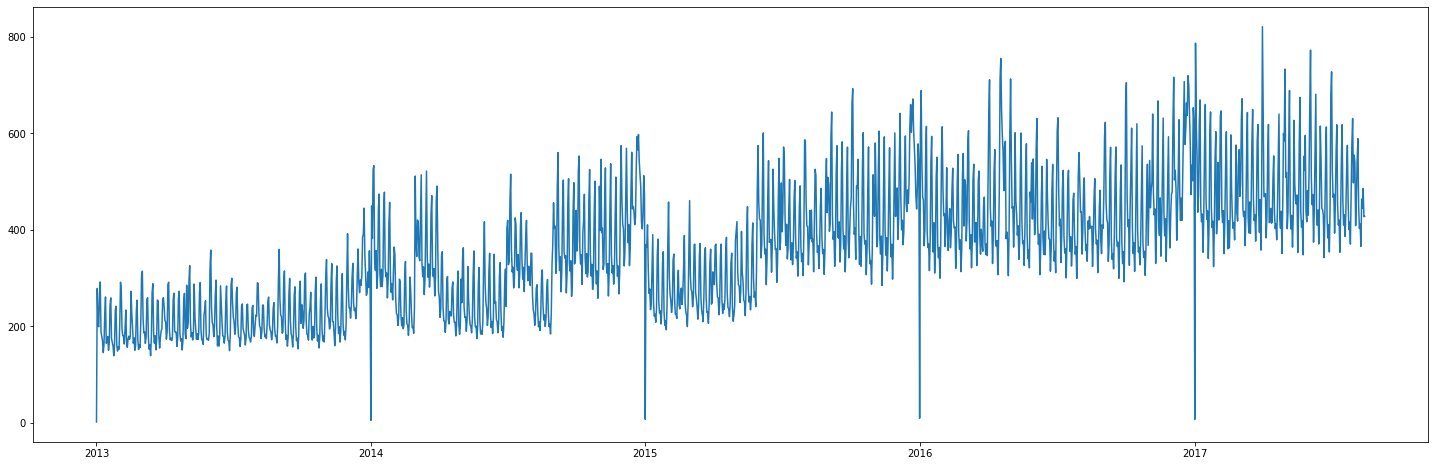

In [98]:
# Plotting average sales vs time

fig, ax = plt.subplots(figsize=(25,8))
ax.plot(average_sales,'-')

In [99]:
# Getting features to check seasonality

seasonality = average_sales_df.sales.to_frame()
seasonality['day']=seasonality.index.day_of_week
seasonality['week'] = seasonality.index.week
seasonality['month'] = seasonality.index.month
seasonality['year'] = seasonality.index.year
seasonality['doy']=seasonality.index.day_of_year # doy = day of the year
seasonality

C:\Users\andreprovensi\AppData\Local\Temp\ipykernel_17284\941604723.py:5: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  seasonality['week'] = seasonality.index.week


,sales,day,week,month,year,doy
date,,,,,,
2013-01-01,1.409438,1,1,1,2013,1
2013-01-02,278.390808,2,1,1,2013,2
2013-01-03,202.840195,3,1,1,2013,3
2013-01-04,198.911148,4,1,1,2013,4
2013-01-05,267.873230,5,1,1,2013,5
...,...,...,...,...,...,...
2017-08-11,463.733856,4,32,8,2017,223
2017-08-12,444.798279,5,32,8,2017,224
2017-08-13,485.768616,6,32,8,2017,225


c:\Users\andreprovensi\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='doy', ylabel='sales'>

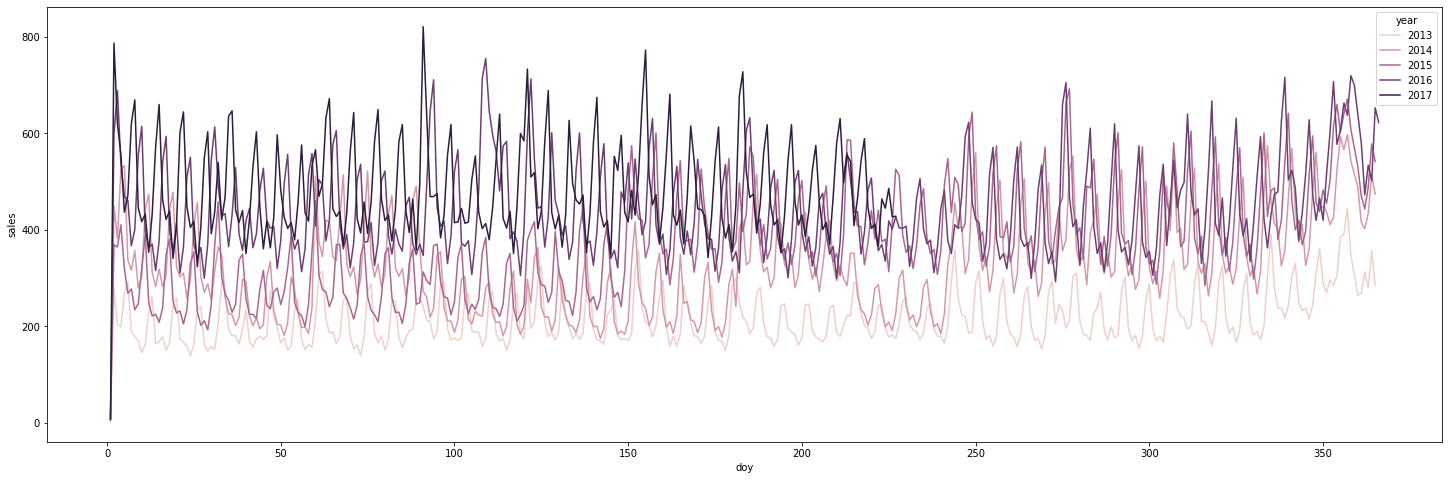

In [100]:
#Checking annual seasonality

Xfig, ax = plt.subplots(figsize=(25,8))
sns.lineplot(seasonality.doy,seasonality.sales,hue=seasonality.year,ci=None)

c:\Users\andreprovensi\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='month', ylabel='sales'>

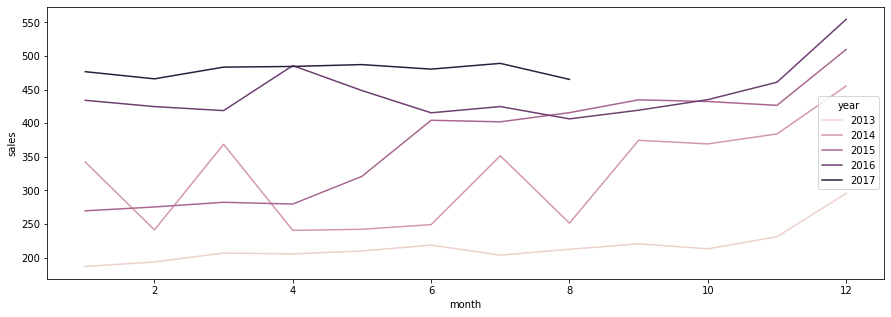

In [101]:
# Checking monthly seasonality
# Average sales tend to increase at the end of the year

fig, ax = plt.subplots(figsize=(15,5))
sns.lineplot(seasonality.month,seasonality.sales,hue=seasonality.year,ci=None)


c:\Users\andreprovensi\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='day', ylabel='sales'>

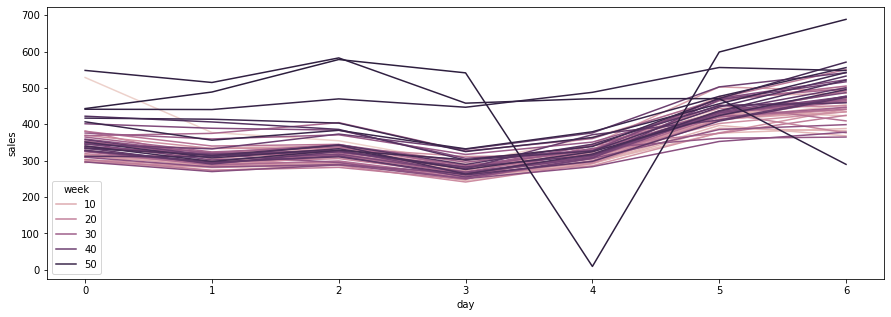

In [102]:
#Checking weekly seasonality
# Average sales are higher at monday and sunday

fig, ax = plt.subplots(figsize=(15,5))
sns.lineplot(seasonality.day,seasonality.sales,hue=seasonality.week,ci=None)

In [103]:
# Preparing features

# The model to be fitted will be:
# average_sales = (Coefficients) dot_product (Days Of Week... , Months... , Fourier Series Terms)
# Days of week:  dummie feature, e.g: Monday = (1,0,0,0,0,0,0) ;  Tuesday = (0,1,0,0,0,0,0) ...
# Month: dummie feature, e.g: January = (1,0,0,0,0,0,0,0,0,0,0,0)


x = seasonality.copy()
x

,sales,day,week,month,year,doy
date,,,,,,
2013-01-01,1.409438,1,1,1,2013,1
2013-01-02,278.390808,2,1,1,2013,2
2013-01-03,202.840195,3,1,1,2013,3
2013-01-04,198.911148,4,1,1,2013,4
2013-01-05,267.873230,5,1,1,2013,5
...,...,...,...,...,...,...
2017-08-11,463.733856,4,32,8,2017,223
2017-08-12,444.798279,5,32,8,2017,224
2017-08-13,485.768616,6,32,8,2017,225


In [104]:
fourier = CalendarFourier(freq="M", order=8)  # 8 sin/cos pairs for "A"nnual seasonality
dp = DeterministicProcess(
    index=average_sales_df.index,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=1,             # the time dummy (trend)
    drop=True,           # drop terms if necessary to avoid collinearity
    additional_terms=[fourier]
    )
x_daily = dp.in_sample()
x_daily

# the trend column stands for the feature for a linear trend



,const,trend,"sin(1,freq=M)","cos(1,freq=M)","sin(2,freq=M)","cos(2,freq=M)","sin(3,freq=M)","cos(3,freq=M)","sin(4,freq=M)","cos(4,freq=M)","sin(5,freq=M)","cos(5,freq=M)","sin(6,freq=M)","cos(6,freq=M)","sin(7,freq=M)","cos(7,freq=M)","sin(8,freq=M)","cos(8,freq=M)"
date,,,,,,,,,,,,,,,,,,
2013-01-01,1.0,1.0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
2013-01-02,1.0,2.0,0.201299,0.979530,0.394356,0.918958,0.571268,0.820763,0.724793,0.688967,0.848644,0.528964,0.937752,0.347305,0.988468,0.151428,0.998717,-0.050649
2013-01-03,1.0,3.0,0.394356,0.918958,0.724793,0.688967,0.937752,0.347305,0.998717,-0.050649,0.897805,-0.440394,0.651372,-0.758758,0.299363,-0.954139,-0.101168,-0.994869
2013-01-04,1.0,4.0,0.571268,0.820763,0.937752,0.347305,0.968077,-0.250653,0.651372,-0.758758,0.101168,-0.994869,-0.485302,-0.874347,-0.897805,-0.440394,-0.988468,0.151428
2013-01-05,1.0,5.0,0.724793,0.688967,0.998717,-0.050649,0.651372,-0.758758,-0.101168,-0.994869,-0.790776,-0.612106,-0.988468,0.151428,-0.571268,0.820763,0.201299,0.979530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-11,1.0,1680.0,0.897805,-0.440394,-0.790776,-0.612106,-0.201299,0.979530,0.968077,-0.250653,-0.651372,-0.758758,-0.394356,0.918958,0.998717,-0.050649,-0.485302,-0.874347
2017-08-12,1.0,1681.0,0.790776,-0.612106,-0.968077,-0.250653,0.394356,0.918958,0.485302,-0.874347,-0.988468,0.151428,0.724793,0.688967,0.101168,-0.994869,-0.848644,0.528964
2017-08-13,1.0,1682.0,0.651372,-0.758758,-0.988468,0.151428,0.848644,0.528964,-0.299363,-0.954139,-0.394356,0.918958,0.897805,-0.440394,-0.968077,-0.250653,0.571268,0.820763


In [105]:
x = x.join(x_daily)

In [106]:
x = pd.get_dummies(data=x,columns=['day'])



In [107]:
x = pd.get_dummies(data=x,columns=['month'])




In [108]:
# Renaming the columns after the get_dummies method
week_dict  = {'day_0':'Monday','day_1':'Tuesday','day_2':'Wednesday','day_3':'Wednesday','day_4':'Thursday','day_5':'Friday','day_6':'Saturday'}
month_dict={
    'month_1':'January',
    'month_2':'February',
    'month_3':'March',
    'month_4':'April',
    'month_5':'May',
    'month_6':'June',
    'month_7':'July',
    'month_8':'August',
    'month_9':'September',
    'month_10':'October',
    'month_11':'November',
    'month_12':'December'
}
x.rename(columns=week_dict,inplace=True)
x.rename(columns=month_dict,inplace=True)
x.drop(columns=['week','doy','year','sales'],inplace=True)

In [109]:
x


,const,trend,"sin(1,freq=M)","cos(1,freq=M)","sin(2,freq=M)","cos(2,freq=M)","sin(3,freq=M)","cos(3,freq=M)","sin(4,freq=M)","cos(4,freq=M)",...,March,April,May,June,July,August,September,October,November,December
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1.0,1.0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,...,0,0,0,0,0,0,0,0,0,0
2013-01-02,1.0,2.0,0.201299,0.979530,0.394356,0.918958,0.571268,0.820763,0.724793,0.688967,...,0,0,0,0,0,0,0,0,0,0
2013-01-03,1.0,3.0,0.394356,0.918958,0.724793,0.688967,0.937752,0.347305,0.998717,-0.050649,...,0,0,0,0,0,0,0,0,0,0
2013-01-04,1.0,4.0,0.571268,0.820763,0.937752,0.347305,0.968077,-0.250653,0.651372,-0.758758,...,0,0,0,0,0,0,0,0,0,0
2013-01-05,1.0,5.0,0.724793,0.688967,0.998717,-0.050649,0.651372,-0.758758,-0.101168,-0.994869,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-11,1.0,1680.0,0.897805,-0.440394,-0.790776,-0.612106,-0.201299,0.979530,0.968077,-0.250653,...,0,0,0,0,0,1,0,0,0,0
2017-08-12,1.0,1681.0,0.790776,-0.612106,-0.968077,-0.250653,0.394356,0.918958,0.485302,-0.874347,...,0,0,0,0,0,1,0,0,0,0
2017-08-13,1.0,1682.0,0.651372,-0.758758,-0.988468,0.151428,0.848644,0.528964,-0.299363,-0.954139,...,0,0,0,0,0,1,0,0,0,0


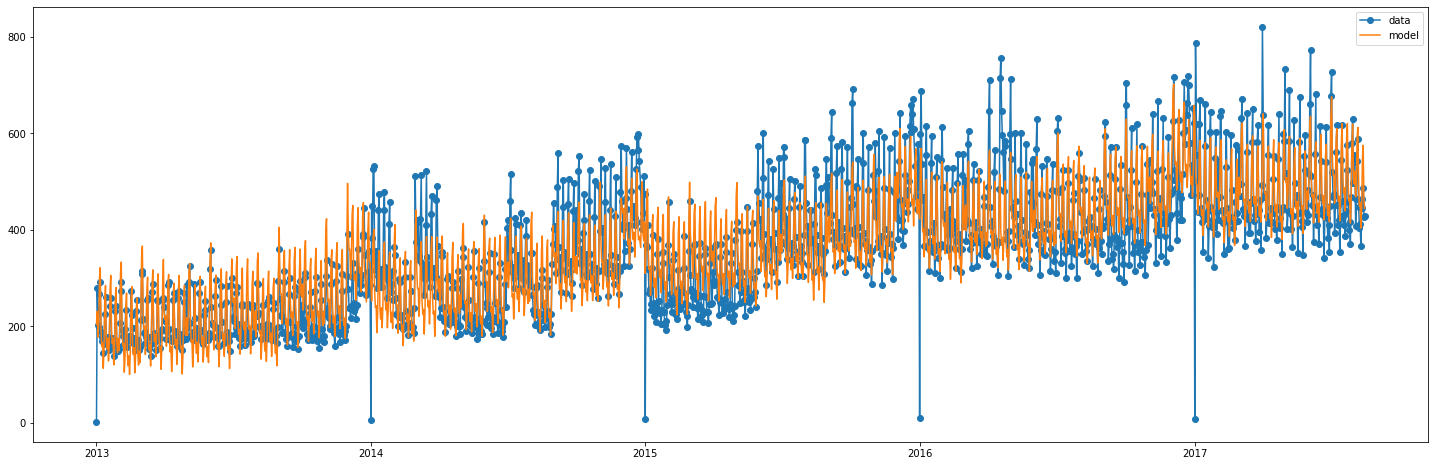

In [110]:
ini = 0 # initial point
fin = len(x.index) # final point

myModel = LinearRegression()

y = average_sales_df.sales

myModel.fit(x,y)

y_pred = pd.Series(myModel.predict(x),index=x.index)

fig, ax = plt.subplots(figsize=(25,8))
ax.plot(average_sales_df.sales.iloc[ini:fin],'o-')
ax.plot(y_pred.iloc[ini:fin],'-')
plt.legend(['data','model'])


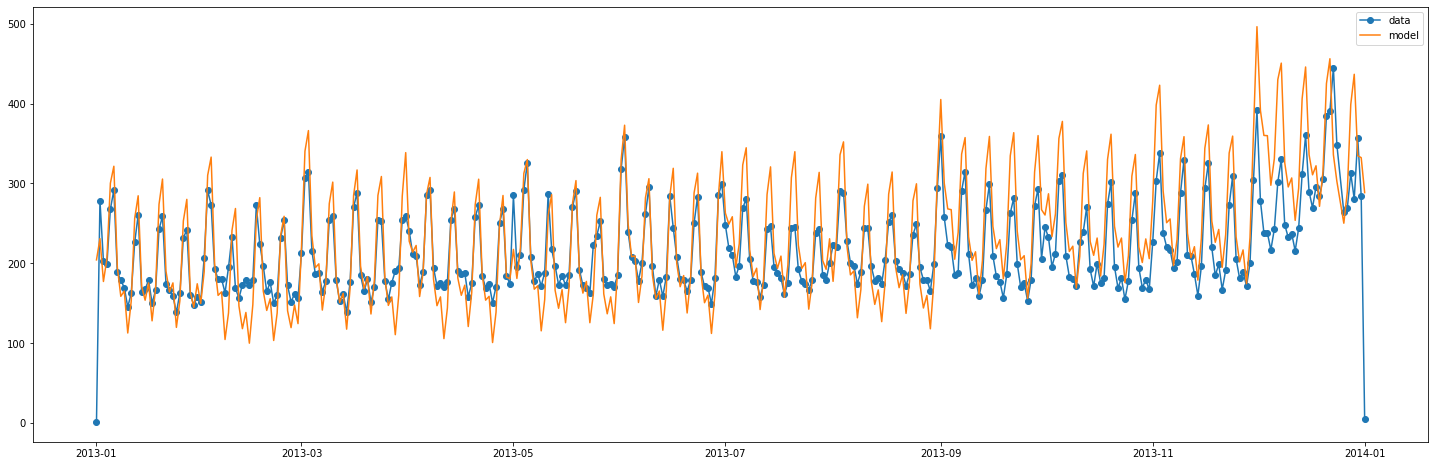

In [111]:
ini = 0
fin = 365

fig, ax = plt.subplots(figsize=(25,8))
ax.plot(average_sales_df.sales.iloc[ini:fin],'o-')
ax.plot(y_pred.iloc[ini:fin],'-')
plt.legend(['data','model'])

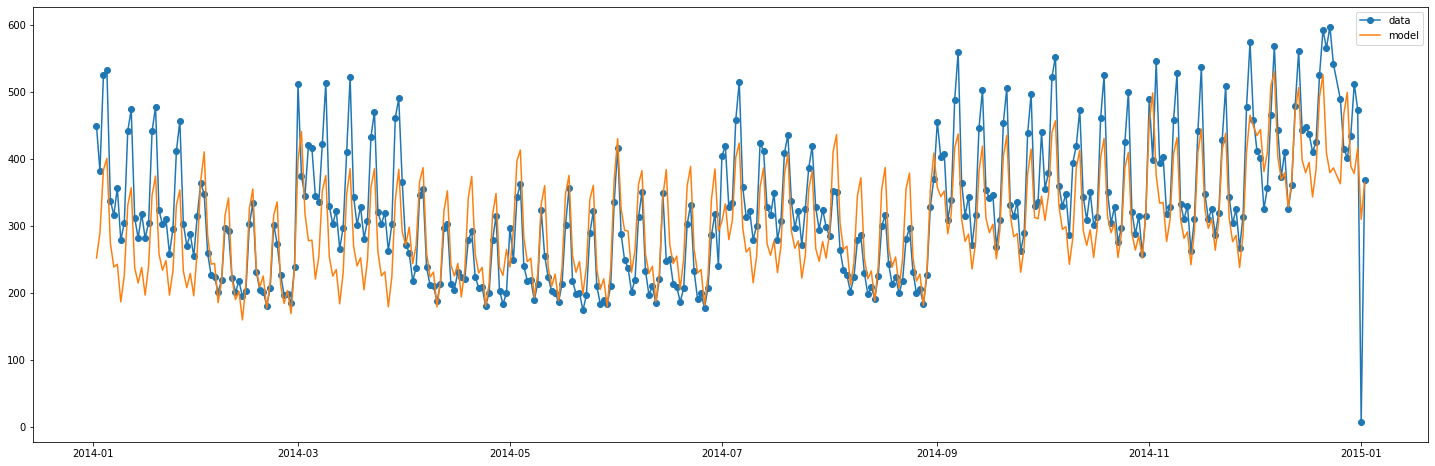

In [112]:
ini = 365
fin = 730

fig, ax = plt.subplots(figsize=(25,8))
ax.plot(average_sales_df.sales.iloc[ini:fin],'o-')
ax.plot(y_pred.iloc[ini:fin],'-')
plt.legend(['data','model'])